In [1]:
# https://www.kaggle.com/thevidyy/scikit-learn-ml-from-start-to-finish-03b16d

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


data_train = pd.read_csv('input/train.csv')
data_test = pd.read_csv('input/test.csv')
data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
348,349,1,3,"Coutts, Master. William Loch ""William""",male,3.0,1,1,C.A. 37671,15.900,NaN,S
244,245,0,3,"Attalah, Mr. Sleiman",male,30.0,0,0,2694,7.225,NaN,C
157,158,0,3,"Corn, Mr. Harry",male,30.0,0,0,SOTON/OQ 392090,8.050,NaN,S


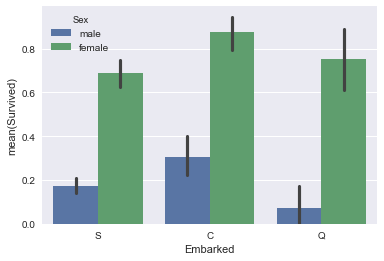

In [3]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

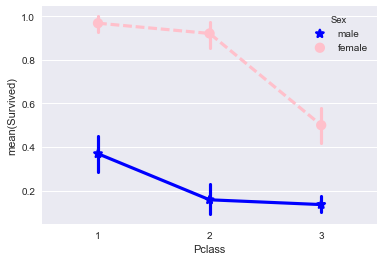

In [4]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
             palette={"male":"blue", "female":"pink"},
             markers=["*", "o"], linestyles=["-", "--"]);

In [5]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student',
                   'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile',
                  '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


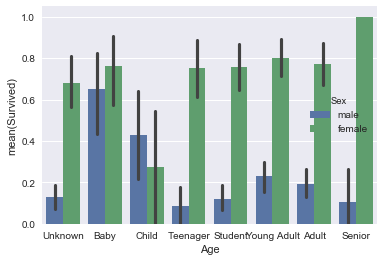

In [6]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

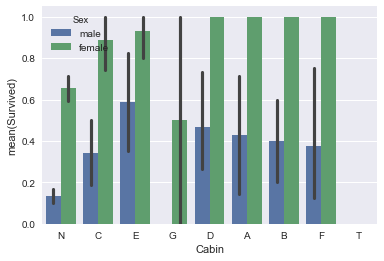

In [7]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

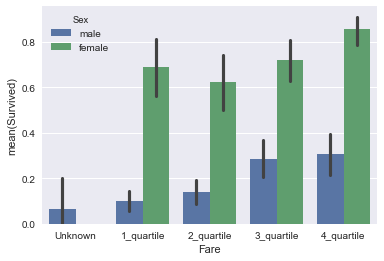

In [8]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

In [9]:
from sklearn import preprocessing

def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [10]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
Y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(
    X_all, Y_all, test_size=num_test, random_state=23)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators':[4,6,9],
             'max_features':['log2', 'sqrt', 'auto'],
             'criterion':['entropy', 'gini'],
             'max_depth':[2, 3, 5, 10],
             'min_samples_split':[2, 3, 5],
             'min_samples_leaf':[1, 5, 8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, Y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to data
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
predictions = clf.predict(X_test)
print(accuracy_score(Y_test, predictions))

0.810055865922


In [13]:
from sklearn.model_selection import KFold

def run_fold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        Y_train, Y_test = Y_all.values[train_index], Y_all.values[test_index]
        clf.fit(X_train, Y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))
    
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))
    
run_fold(clf)

Fold 1 accuracy: 0.8
Fold 2 accuracy: 0.8876404494382022
Fold 3 accuracy: 0.797752808988764
Fold 4 accuracy: 0.8539325842696629
Fold 5 accuracy: 0.8764044943820225
Fold 6 accuracy: 0.8089887640449438
Fold 7 accuracy: 0.7865168539325843
Fold 8 accuracy: 0.7640449438202247
Fold 9 accuracy: 0.8876404494382022
Fold 10 accuracy: 0.8539325842696629
Mean Accuracy: 0.8316853932584269


In [14]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))
output = pd.DataFrame({'PassengerId':ids, 'Survived':predictions})
output.to_csv('output/titanic-predictions01.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
